In [1]:
# imports
import cv2
from tensorflow.python.lib.io import file_io
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import tensorflow as tf


/Users/farrar/py3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
# constants
TRAIN_PATH = '../stage1_train'
TEST_PATH = '../stage1_test'
LABEL_PATH = '../stage1_labels/train.csv'
OUTPUT_PATH = '../stage1_submit'
COLORS = ['red','green', 'blue', 'yellow']
IMAGE_SIZE = 512
CROP_SIZE = 256
BATCH_SIZE = 2
SHAPE = (CROP_SIZE, CROP_SIZE, 4)
THRESHOLD = 0.05
SEED = 42


name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [4]:
# -----------------------------------------
# get a list of unique specimen ids
# -----------------------------------------
def get_specimen_ids(path):

    # get a list of all the images
    file_list = file_io.list_directory(path)
    
    # truncate the file names to make a specimen id
    specimen_ids = [f[:36] for f in file_list]
    
    # eliminate duplicates
    specimen_ids = list(set(specimen_ids))
    
    return specimen_ids

# unit test
specimen_list = get_specimen_ids(TRAIN_PATH)
print(specimen_list)

['fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0', '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0', '001838f8-bbca-11e8-b2bc-ac1f6b6435d0', 'fc84a97c-bbad-11e8-b2ba-ac1f6b6435d0', '0020af02-bbba-11e8-b2ba-ac1f6b6435d0', '002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', '001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0', 'ffeae6f0-bbc9-11e8-b2bc-ac1f6b6435d0', 'fea6e496-bbbb-11e8-b2ba-ac1f6b6435d0', 'fb4c1fac-bbaa-11e8-b2ba-ac1f6b6435d0']


In [5]:
def get_image_fname(path, specimen_id, color, lo_res=True):

    # construct filename
    if lo_res:
        fname = path + '/' + specimen_id + '_' + color + '.png'
    else:
        fname = path + '/' + specimen_id + '_' + color + '.tif'
        
    return fname

# unit test
s = '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0'
f = get_image_fname(TRAIN_PATH, s, 'red')
print(f)

../stage1_train/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0_red.png


In [6]:
train_labels = pd.read_csv(LABEL_PATH)
train_labels.head(10)


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
5,001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0
6,0020af02-bbba-11e8-b2ba-ac1f6b6435d0,25 2
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0
8,00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,2 0
9,002daad6-bbc9-11e8-b2bc-ac1f6b6435d0,7


In [7]:
selection_list = ['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', s, '001838f8-bbca-11e8-b2bc-ac1f6b6435d0']
subset = train_labels.loc[train_labels['Id'].isin(selection_list)]
subset.head()
split_labels = (subset.loc[subset['Id'] == '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0'])['Target'].str.split(' ')
print (split_labels)

1    [7, 1, 2, 0]
Name: Target, dtype: object


In [8]:
# ---------------------------------------
# Keras style run time data generator
# ---------------------------------------
class HproteinDataGenerator(keras.utils.Sequence):
    
    # ---------------------------------------------
    # Required function to initialize the class
    # ---------------------------------------------
    def __init__(self, 
                 path,
                 specimen_ids, 
                 labels, 
                 batch_size=BATCH_SIZE,
                 image_size=IMAGE_SIZE,
                 crop_size=CROP_SIZE,
                 shape=SHAPE, 
                 shuffle=True, 
                 use_cache=False, 
                 augment=False):
       
        self.path = path                       # path where data generator will find data
        self.specimen_ids = specimen_ids       # list of features
        self.labels = labels                   # list of labels
        self.batch_size = batch_size           # batch size
        self.image_size = image_size
        self.crop_size = crop_size             # size to crop images to
        self.last_batch_padding = 0            # amount to pad the last batch to make it complete
        self.shape = shape                     # shape of features
        self.shuffle = shuffle                 # boolean for shuffle
        self.use_cache = use_cache             # boolean for use of cache
        self.augment = augment                 # boolean for image augmentation
        
    # -------------------------------------------------------
    # Required function to determine the number of batches
    # -------------------------------------------------------
    def __len__(self):
        
        # get the number of examples to generate
        example_count = len(self.specimen_ids)
        
        # calculate the number of batches
        batch_count = int(np.ceil(example_count / float(self.batch_size)))
        
        # get the size of the last batch
        last_batch_size = example_count - ((batch_count - 1) * self.batch_size)
        
        # set the amount to pad the last batch
        self.last_batch_padding = self.batch_size - last_batch_size
        
        return batch_count
    
    # -------------------------------------------------------
    # Required function to get a batch
    # -------------------------------------------------------
    def __getitem__(self, index):
        
        # get the list of specimen ids for this batch
        specimen_ids = self.specimen_ids[self.batch_size*index:self.batch_size*(index + 1)]
                
        # create a zeroed out numpy array to load the batch into
        feature_batch = np.zeros((len(specimen_ids), self.shape[0], self.shape[1], self.shape[2]))
        
        # load a batch of labels
        label_batch = self.labels[self.batch_size*index:self.batch_size*(index + 1)]
        
        # load the batch with images and crop
        for i, specimen_id in enumerate(specimen_ids):
            feature_batch[i] = self.get_stacked_image(specimen_id)
            
        # augment images if desired
        if self.augment:
            print("Error: Image augmentation not implemented!")
            
        return feature_batch, label_batch
            
            
    # -----------------------------------------
    # get a single image
    # -----------------------------------------
    def get_single_image(self, specimen_id, color, lo_res=True):

        # get image file name
        fname = get_image_fname(self.path, specimen_id, color, lo_res)
        
        # read image as a 1-channel image
        image = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        
        return image
    
            
    # -----------------------------------------
    # get a stacked (4-channel) image
    # -----------------------------------------
    def get_stacked_image(self, specimen_id, lo_res=True):

        # create a numpy array to place the 1-channel images into
        image = np.zeros((self.image_size, self.image_size, 4), dtype=np.uint8)

        for n, color in enumerate(COLORS):

            # get a single image
            i = self.get_single_image(specimen_id, color, lo_res)

            # store it a channel
            image[:, :, n] = i
            
        crop = self.random_crop(image, crop_size=self.crop_size)

        return crop

    
    # --------------------------------------------------
    # crops an image to crop_size from a random origin
    # --------------------------------------------------
    def random_crop(self, image, crop_size=256, original_size=512):
    
        # get a pair of random coordinates that will provide for an image of crop_size
        x_origin = random.randint(0, original_size - crop_size)
        y_origin = random.randint(0, original_size - crop_size)
        
        print('before -> {}'.format(image.shape))
        crop = image[x_origin : x_origin + crop_size, y_origin : y_origin + crop_size, :]
        print('after  -> {}'.format(crop.shape))
        return crop


In [9]:
# -----------------------------------------------------------
# get the available specimen ids and corresponding labels
# -----------------------------------------------------------
def get_train_data(train_path, label_path):
    
    # get the list of specimen ids
    specimen_ids = get_specimen_ids(train_path)
    
    # get the labels for all specimen_ids
    label_data = pd.read_csv(label_path)
    
    # get the subset of labels that match the specimen images that are on TRAIN_PATH
    labels_subset = label_data.loc[label_data['Id'].isin(specimen_ids)]
    
    #
    # convert labels to trainer format
    #
    
    # set up the list that will contain the list of encoded labels for each specimen id
    labels = []
    
    # loop through each specimen_id
    for specimen_id in specimen_ids:
        
        # split the space separated multi-label into a list of individual labels
        split_labels = (labels_subset.loc[labels_subset['Id'] == specimen_id])['Target'].str.split(' ')

        # set up a numpy array to receive the encoded label
        l = np.zeros(28, dtype=np.uint8)

        # turn on the positive columns in the labels array
        for label in split_labels:
            l[np.uint8(label)] = 1
        
        labels.append(l)
        
    return np.array(specimen_ids), np.array(labels)

# unit test 
specimen_ids, labels = get_train_data(TRAIN_PATH, LABEL_PATH)
for sid, l in zip(specimen_ids, labels):
    print('Specimen Id: {} : Labels: {}'.format(sid, l))


Specimen Id: fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0 : Labels: [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: 000c99ba-bba4-11e8-b2b9-ac1f6b6435d0 : Labels: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: 001838f8-bbca-11e8-b2bc-ac1f6b6435d0 : Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Specimen Id: fc84a97c-bbad-11e8-b2ba-ac1f6b6435d0 : Labels: [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: 0020af02-bbba-11e8-b2ba-ac1f6b6435d0 : Labels: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Specimen Id: 002daad6-bbc9-11e8-b2bc-ac1f6b6435d0 : Labels: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: 001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0 : Labels: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: ffeae6f0-bbc9-11e8-b2bc-ac1f6b6435d0 : Labels: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Specimen Id: fea6e496-bbbb-11e8-b2ba-ac1f6b6435d0 : Labe

In [10]:
# -----------------------------------------------------------
# get the specimen ids to predict
# -----------------------------------------------------------
def get_predict_data(test_path, output_path):
    
    # get the list of specimen ids for which there are images
    specimen_ids = get_specimen_ids(test_path)
    
    # get the list of submission specimen ids required
    submit_data = pd.read_csv(output_path + '/sample_submission.csv')
    
    # get the subset of labels that match the specimen images that are on TEST_PATH
    submit_subset = submit_data.loc[submit_data['Id'].isin(specimen_ids)]
    
    # set up the list that will contain the list of encoded labels for each specimen id
    predicted_labels = np.zeros((len(specimen_ids), 28), dtype=np.uint8)
    
    return np.array(specimen_ids), predicted_labels

# unit test 
specimen_ids, labels = get_predict_data(TEST_PATH, OUTPUT_PATH)
for sid, l in zip(specimen_ids, labels):
    print('Specimen Id: {} : Labels: {}'.format(sid, l))


Specimen Id: 0031820a-baca-11e8-b2b8-ac1f6b6435d0 : Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: 003170fa-bacd-11e8-b2b8-ac1f6b6435d0 : Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: 0008baca-bad7-11e8-b2b9-ac1f6b6435d0 : Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: 00d2a4f8-bad6-11e8-b2b9-ac1f6b6435d0 : Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: 000cce7e-bad4-11e8-b2b8-ac1f6b6435d0 : Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: 00cfafb0-bacb-11e8-b2b8-ac1f6b6435d0 : Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Specimen Id: 0006faa6-bac7-11e8-b2b7-ac1f6b6435d0 : Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
# --------------------------------
# calculate the f1 statistic
# --------------------------------
def f1(y_true, y_pred):
    
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    
    return K.mean(f1)

# unit test
y_true = K.variable(np.ones(10, np.uint8))
y_pred = np.ones(10, np.uint8)
y_pred[0] = 0
y_pred = K.variable(y_pred)

ftest = f1(y_true, y_pred)
#ftest = tf.constant(5)

init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)
print (sess.run(ftest))


0.9473683


In [12]:
# --------------------------------
# calculate the f1 loss
# --------------------------------

def f1_loss(y_true, y_pred):

    f = f1(y_true, y_pred)
    
    return 1 - K.mean(f)

# unit test
y_true = K.variable(np.ones(10, np.uint8))
y_pred = np.ones(10, np.uint8)
y_pred[0] = 0
y_pred = K.variable(y_pred)

ftest = f1_loss(y_true, y_pred)
#ftest = tf.constant(5)

init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)
print (sess.run(ftest))

0.052631676


In [13]:
# ------------------------------
# create the model
# ------------------------------
def create_model(input_shape):

    dropRate = 0.25
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(8, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(8, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(16, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    c1 = Conv2D(16, (3, 3), padding='same')(x)
    c1 = ReLU()(c1)
    c2 = Conv2D(16, (5, 5), padding='same')(x)
    c2 = ReLU()(c2)
    c3 = Conv2D(16, (7, 7), padding='same')(x)
    c3 = ReLU()(c3)
    c4 = Conv2D(16, (1, 1), padding='same')(x)
    c4 = ReLU()(c4)
    x = Concatenate()([c1, c2, c3, c4])
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    #x = Conv2D(256, (1, 1), activation='relu')(x)
    #x = BatchNormalization(axis=-1)(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(28)(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.1)(x)
    x = Dense(28)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model

# unit test
model = create_model(SHAPE)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 254, 254, 8)  296         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 254, 254, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [14]:
# get data
def get_data(test_size=0.1):
    
    specimen_ids, labels = get_train_data(TRAIN_PATH, LABEL_PATH)
    train_set_sids, val_set_sids, train_set_lbls, val_set_lbls = train_test_split(specimen_ids, labels, test_size=test_size, random_state=SEED)
    
    return train_set_sids, val_set_sids, train_set_lbls, val_set_lbls

# unit test
train_set_sids, val_set_sids, train_set_lbls, val_set_lbls = get_data(test_size=0.3)
print (train_set_sids.shape)
print (val_set_sids.shape)

# create data generators
tg = HproteinDataGenerator(TRAIN_PATH, train_set_sids, train_set_lbls)
vg = HproteinDataGenerator(TRAIN_PATH, val_set_sids, val_set_lbls)
print(len(tg))
print(len(vg))
print (val_set_sids, val_set_lbls)



(7,)
(3,)
4
2
['fea6e496-bbbb-11e8-b2ba-ac1f6b6435d0'
 '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0'
 '002daad6-bbc9-11e8-b2bc-ac1f6b6435d0'] [[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [15]:
checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

In [16]:
epochs = 5

use_multiprocessing = False # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

hist = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

Epoch 1/5
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
3/4 [=====================>........] - ETA: 1s - loss: 0.7448 - acc: 0.6667 - f1: 0.0754before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256

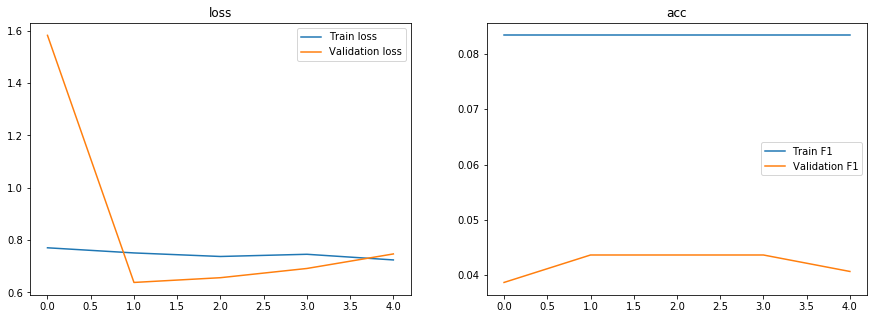

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [18]:
final_model = load_model('./base.model', custom_objects={'f1': f1})

In [19]:
val_predictions = np.empty((0, 28))
val_labels = np.empty((0, 28))
for i in range(len(vg)):
    image, label = vg[i]
    scores = final_model.predict(image)
    #print('scores -> {}'.format(scores))
    #print('label  -> {}'.format(label))
    val_predictions = np.append(val_predictions, scores, axis=0)
    val_labels = np.append(val_labels, label, axis=0)
print(val_predictions.shape)
print(val_labels.shape)
print(val_predictions)

before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
(3, 28)
(3, 28)
[[0.25240365 0.55149066 0.13841696 0.42964354 0.42269263 0.38355693
  0.42369771 0.23436081 0.71587414 0.69582075 0.73850542 0.57660568
  0.85191613 0.38432184 0.73817503 0.23672265 0.50334758 0.2530283
  0.7095232  0.37436184 0.33581984 0.40107554 0.18683967 0.34871626
  0.43545547 0.51464313 0.09347416 0.84290659]
 [0.23921522 0.87769157 0.38930225 0.65958738 0.71748734 0.31304604
  0.81351763 0.47168934 0.46793547 0.6009683  0.43323007 0.12473943
  0.80076122 0.22870333 0.62477964 0.35525015 0.53582162 0.40971136
  0.52460194 0.2769497  0.25414637 0.78282976 0.4496924  0.02824184
  0.35052133 0.79163474 0.10372406 0.81564993]
 [0.10307997 0.82615042 0.59705108 0.50977743 0.37806016 0.46277297
  0.69885528 0.38594684 0.35026035 0.57017308 0.26372519 0.54506254
  0.62027407 0.03525889 0.2761201  0.25585717 0.19295003 0.57194954

In [20]:
from sklearn.metrics import f1_score
rng = np.arange(0, 1, 0.001)
fscores = np.zeros((rng.shape[0], 28))
for j,k in enumerate(rng):
    for i in range(28):
        p = np.array(val_predictions[:,i]>k, dtype=np.int8)
        #print('p -> {}'.format(p))
        #print('v -> {}'.format(val_predictions[:,i]))
        #print('l -> {}'.format(val_labels[:,i]))
        score = f1_score(val_labels[:,i], p, average='binary')
        #print(score)
        fscores[j,i] = score
        
        
print (fscores.shape)
print (fscores)


/Users/farrar/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/farrar/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(1000, 28)
[[0.  0.5 0.  ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


In [21]:
print('Individual F1-scores for each class:')
print(np.max(fscores, axis=0))
print('Macro F1-score CV =', np.mean(np.max(fscores, axis=0)))

Individual F1-scores for each class:
[0.         1.         0.         0.         0.         0.
 0.         0.66666667 0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Macro F1-score CV = 0.09523809523809523


Probability threshold maximizing CV F1-score for each class:
[0.    0.827 0.    0.    0.    0.    0.    0.235 0.    0.    0.    0.
 0.801 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


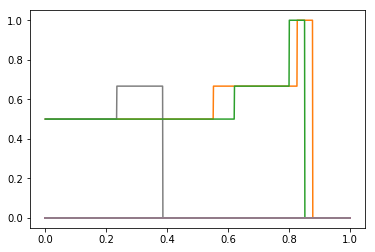

In [22]:
plt.plot(rng, fscores)
p_threshold = np.empty(28)
for i in range(28):
    p_threshold[i] = rng[np.where(fscores[:,i] == np.max(fscores[:,i]))[0][0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(p_threshold)

In [23]:
predict_set_sids, predict_set_lbls = get_predict_data(TEST_PATH, OUTPUT_PATH)
pg = HproteinDataGenerator(TEST_PATH, predict_set_sids, predict_set_lbls)

print(len(pg))
print(pg.last_batch_padding)
print (predict_set_sids, predict_set_lbls)


4
1
['0031820a-baca-11e8-b2b8-ac1f6b6435d0'
 '003170fa-bacd-11e8-b2b8-ac1f6b6435d0'
 '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '00d2a4f8-bad6-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0'
 '00cfafb0-bacb-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'] [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [24]:
predictions = np.zeros((predict_set_sids.shape[0] + pg.last_batch_padding, 28))
for i in range(len(pg)):
    images, labels = pg[i]
    if (images.shape[0] < pg.batch_size):
        blank_rows = np.zeros((pg.last_batch_padding, pg.shape[0], pg.shape[1], pg.shape[2]))
        print('blank rows shape {}'.format(blank_rows.shape))
        images = np.append(images, blank_rows, axis=0)
        print ('Images Shape After: {}'.format(images.shape))
    score = final_model.predict(images)
    predictions[i*BATCH_SIZE:i*BATCH_SIZE+images.shape[0]] = score
    
print (predictions)


before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
before -> (512, 512, 4)
after  -> (256, 256, 4)
blank rows shape (1, 256, 256, 4)
Images Shape After: (2, 256, 256, 4)
[[0.49203286 0.727247   0.44252595 0.56971371 0.43764538 0.25350571
  0.44199121 0.29554486 0.80962384 0.28566882 0.40786505 0.33592352
  0.58073068 0.2174053  0.27452123 0.48976725 0.64190465 0.26698059
  0.45333162 0.19163099 0.58014166 0.74943238 0.36747578 0.27175003
  0.13558222 0.65302014 0.19112986 0.84009117]
 [0.28555158 0.93474996 0.56902039 0.43386447 0.47201371 0.6327278
  0.71014196 0.54668033 0.66552699 0.3940815  0.40079966 0.50843662
  0.43487269 0.09682455 0.5326004  0.34296384 0.43719587 0.42371759
  0.3921037  0.51509225 0.75620443 0.86453295 0.06199847 0.05415692
  0

In [25]:
# get the list of submission specimen ids required
submit_data = pd.read_csv(OUTPUT_PATH + '/sample_submission.csv')

# get the subset of labels that match the specimen images that are on TEST_PATH
submit_data = submit_data.loc[submit_data['Id'].isin(specimen_ids)]


In [26]:
prediction_str = []
print(predictions.shape)
predictions = predictions[:predictions.shape[0] - pg.last_batch_padding, :]
for i in range(predictions.shape[0]):
    submit_str = ' '
    for j in range(predictions.shape[1]):
        if predictions[i,j] >= p_threshold[j]:
            submit_str += str(j) + ' '
            
    prediction_str.append(submit_str)
    
submit_data['Predicted'] = np.array(prediction_str)

submit_data.to_csv(OUTPUT_PATH + '/submit_3434.csv', index=False)
            
            

(8, 28)


In [27]:
'''
def random_crop(image, crop_size=256, original_size=512):
    
    # get a pair of random coordinates that will provide for an image of crop_size
    x_origin = random.randint(0, original_size - crop_size)
    y_origin = random.randint(0, original_size - crop_size)
    
    crop = image[x_origin : x_origin + crop_size, y_origin : y_origin + crop_size, :]
    
    return crop

# unit test
img, lbl = tg[0]
image = img[i]
crop = random_crop(image, crop_size=128, original_size=256)
print('Shape before -> {}'.format(image.shape))
print('Shape after  -> {}'.format(crop.shape))
'''    

"\ndef random_crop(image, crop_size=256, original_size=512):\n    \n    # get a pair of random coordinates that will provide for an image of crop_size\n    x_origin = random.randint(0, original_size - crop_size)\n    y_origin = random.randint(0, original_size - crop_size)\n    \n    crop = image[x_origin : x_origin + crop_size, y_origin : y_origin + crop_size, :]\n    \n    return crop\n\n# unit test\nimg, lbl = tg[0]\nimage = img[i]\ncrop = random_crop(image, crop_size=128, original_size=256)\nprint('Shape before -> {}'.format(image.shape))\nprint('Shape after  -> {}'.format(crop.shape))\n"